# Hierarchical Clustering — dendrogram cuts and multi-scale grouping
This notebook demonstrates agglomerative clustering on blob data, including preprocessing, fitting, evaluation, and an evolution schema showing clustering at different cut levels.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

sns.set(style="whitegrid")

In [2]:
# Create dataset (reuse blobs with outliers/missing)
rng = np.random.RandomState(42)
X, y = make_blobs(n_samples=800, centers=4, cluster_std=0.6, random_state=42)
# add outliers
n_out = int(0.05 * X.shape[0])
out_idx = rng.choice(X.shape[0], n_out, replace=False)
X[out_idx] += rng.normal(0, 8.0, size=(n_out, X.shape[1]))
# missing
n_nan = max(1, int(0.01 * X.size))
rows = rng.randint(0, X.shape[0], n_nan)
cols = rng.randint(0, X.shape[1], n_nan)
X[rows, cols] = np.nan

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
# Preprocess
imputer = SimpleImputer(strategy='mean')
Xtr_imp = imputer.fit_transform(X_train)
Xte_imp = imputer.transform(X_test)

scaler = RobustScaler()
Xtr = scaler.fit_transform(Xtr_imp)
Xte = scaler.transform(Xte_imp)

In [4]:
# Fit hierarchical and evaluate
agg = AgglomerativeClustering(n_clusters=4)
labels_tr = agg.fit_predict(Xtr)
labels_te = agg.fit_predict(Xte)

metrics = {
    'ARI_train': adjusted_rand_score(y_train, labels_tr),
    'NMI_train': normalized_mutual_info_score(y_train, labels_tr),
    'Silhouette_train': silhouette_score(Xtr, labels_tr) if len(set(labels_tr))>1 else np.nan,
    'ARI_test': adjusted_rand_score(y_test, labels_te),
    'NMI_test': normalized_mutual_info_score(y_test, labels_te),
    'Silhouette_test': silhouette_score(Xte, labels_te) if len(set(labels_te))>1 else np.nan,
}
for k, v in metrics.items():
    print(f"{k}: {v}")

ARI_train: 0.9250782358659648
NMI_train: 0.8945410195602583
Silhouette_train: 0.8302956225737628
ARI_test: 0.8525493921315382
NMI_test: 0.82647047732375
Silhouette_test: 0.8126381284997419


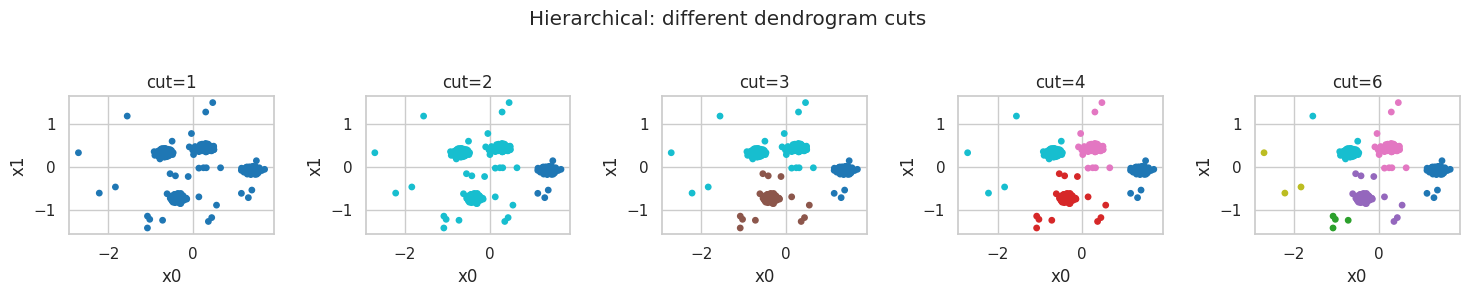

In [5]:
# Evolution: cut dendrogram at different cluster counts
Z = linkage(Xtr, method='ward')
cut_vals = [1, 2, 3, 4, 6]
fig, axes = plt.subplots(1, len(cut_vals), figsize=(15, 3))
for ax, nc in zip(axes, cut_vals):
    labels = fcluster(Z, t=nc, criterion='maxclust')
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=labels, cmap='tab10', s=15)
    ax.set_title(f'cut={nc}')
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
plt.suptitle('Hierarchical: different dendrogram cuts')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

Hierarchical — Clear explanation with keywords

Hierarchical clustering builds a tree of clusters by merging points or groups step by step.

Key terms and short explanations:

- **Dendrogram** — a tree diagram that shows how clusters are merged at each step; cutting it at a height gives a set of clusters.
- **Cut** — choosing a level in the dendrogram to extract a desired number of clusters.
- **Linkage** — the rule that defines the distance between clusters when deciding which to merge (e.g., single, complete, ward).
- **Resolution** — different cuts show cluster structure at different granularities (coarse vs fine groups).

When to use hierarchical clustering: use it to explore data structure at multiple scales or when you want a visual tree of groupings. It can be slow on very large datasets.

Conclusion / Observations

- The hierarchical clustering visualizations show how clusters **merge** as you move up the dendrogram; lower cuts give finer groups while higher cuts produce coarser groupings.
- Results depend on **linkage** choice and can differ near cluster boundaries; hierarchical methods are useful for exploratory analysis and when a tree view is desired.
- For larger datasets, hierarchical clustering can be **computationally expensive**; consider sampling or alternative algorithms.

Next steps: plot the actual dendrogram for inspection, try different linkage methods (single, complete, ward), and compare cluster assignments using ARI/NMI across cuts.